<a href="https://colab.research.google.com/github/Swastik200/30DaysOfDSA/blob/main/tryGeneticLSTMFD001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp "/content/drive/MyDrive/cmapss.zip" "/content"
!unzip cmapss.zip

Archive:  cmapss.zip
  inflating: cmapss/readme.txt       
  inflating: cmapss/RUL_FD001.txt    
  inflating: cmapss/RUL_FD002.txt    
  inflating: cmapss/RUL_FD003.txt    
  inflating: cmapss/RUL_FD004.txt    
  inflating: cmapss/test_FD001.txt   
  inflating: cmapss/test_FD002.txt   
  inflating: cmapss/test_FD003.txt   
  inflating: cmapss/test_FD004.txt   
  inflating: cmapss/train_FD001.txt  
  inflating: cmapss/train_FD002.txt  
  inflating: cmapss/train_FD003.txt  
  inflating: cmapss/train_FD004.txt  
  inflating: cmapss/x.txt            


In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
dataPath = '/content/cmapss/'

In [ ]:
setNumber = 1

In [ ]:
id_col = ['id']
cycle_col = ['cycle']
setting_cols = ['setting1', 'setting2', 'setting3']
sensor_cols = ['sensor' + str(i) for i in range(1, 22)]
rul_col = ['RUL']
all_cols = id_col + cycle_col + setting_cols + sensor_cols + rul_col

In [ ]:
# This section is to load data
def loadData(fileName):
    data = pd.read_csv(fileName, sep=" ", header=None)
    data.drop([26, 27], axis = 1, inplace=True)
    data.columns = id_col + cycle_col + setting_cols +sensor_cols
    return data

In [ ]:
# load train RUL also returns the max cycle, and this max cycle is also the life cylce
def addTrainRul(data, decrease_threshold=None):
    lifeCycles = {mcId: data[data['id']==mcId]['cycle'].max() for mcId in data['id'].unique()}
    if decrease_threshold == None: decrease_threshold = 1
    ruls = [lifeCycles[row[0]] - decrease_threshold if row[1] < decrease_threshold else lifeCycles[row[0]] - row[1] for row in data.values]
    data['RUL'] = ruls
    return lifeCycles

# use this last one only, return the data as well as the max life cycles
def loadTrainData(setNumber, decrease_threshold=None):
    fileName = dataPath + '/train_FD00' + str(setNumber) + '.txt'
    data = loadData(fileName)
    lifeCycles = addTrainRul(data, decrease_threshold)
    return data, lifeCycles

In [ ]:
decrease_threshold = None
train, trainLifeCycles = loadTrainData(setNumber, decrease_threshold)

In [ ]:
def loadTestRul(fileName):
    data = pd.read_csv(fileName, sep = " ", header=None)
    data.drop([1], axis=1, inplace=True)
    data.columns = ['RUL']
    return data
def addTestRul(data, rulData, decrease_threshold=None):
    testRuls = {i+1: rulData.iloc[i, 0] for i in range(len(rulData))}
    lifeCycles = {mcId: data[data['id']==mcId]['cycle'].max() + testRuls[mcId] for mcId in data['id'].unique()}
    if decrease_threshold == None: decrease_threshold = 1
    ruls = [lifeCycles[row[0]] - decrease_threshold if row[1] < decrease_threshold else lifeCycles[row[0]] - row[1] for row in data.values]
    data['RUL'] = ruls
    return lifeCycles
# Use this last one only => return data as well as the max life cycles for each machine
def loadTestData(setNumber, decrease_threshold=None):
    data = loadData(dataPath + '/test_FD00' +str(setNumber)+'.txt')
    rulData = loadTestRul(dataPath + '/RUL_FD00' + str(setNumber)+'.txt')
    lifeCycles = addTestRul(data, rulData, decrease_threshold)
    return data, lifeCycles

In [ ]:
# Also make test RUL becomes piecewise
test, testLifeCycles = loadTestData(setNumber, decrease_threshold)

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
# As of feature selection they often select: 7, 8, 9, 12, 16, 17, 20  (manual selection based on sensor trends)
def plotSensorDataOfId(data, mcId):
    plt.figure(figsize=(30, 20))
    for i in range(21):
        sensor = 'sensor'+str(i+1)
        plt.subplot(10, 3, i+1).set_title(sensor)
        ssdata = data[data['id']==mcId]
        plt.plot(ssdata['cycle'], ssdata[sensor])
    plt.tight_layout()

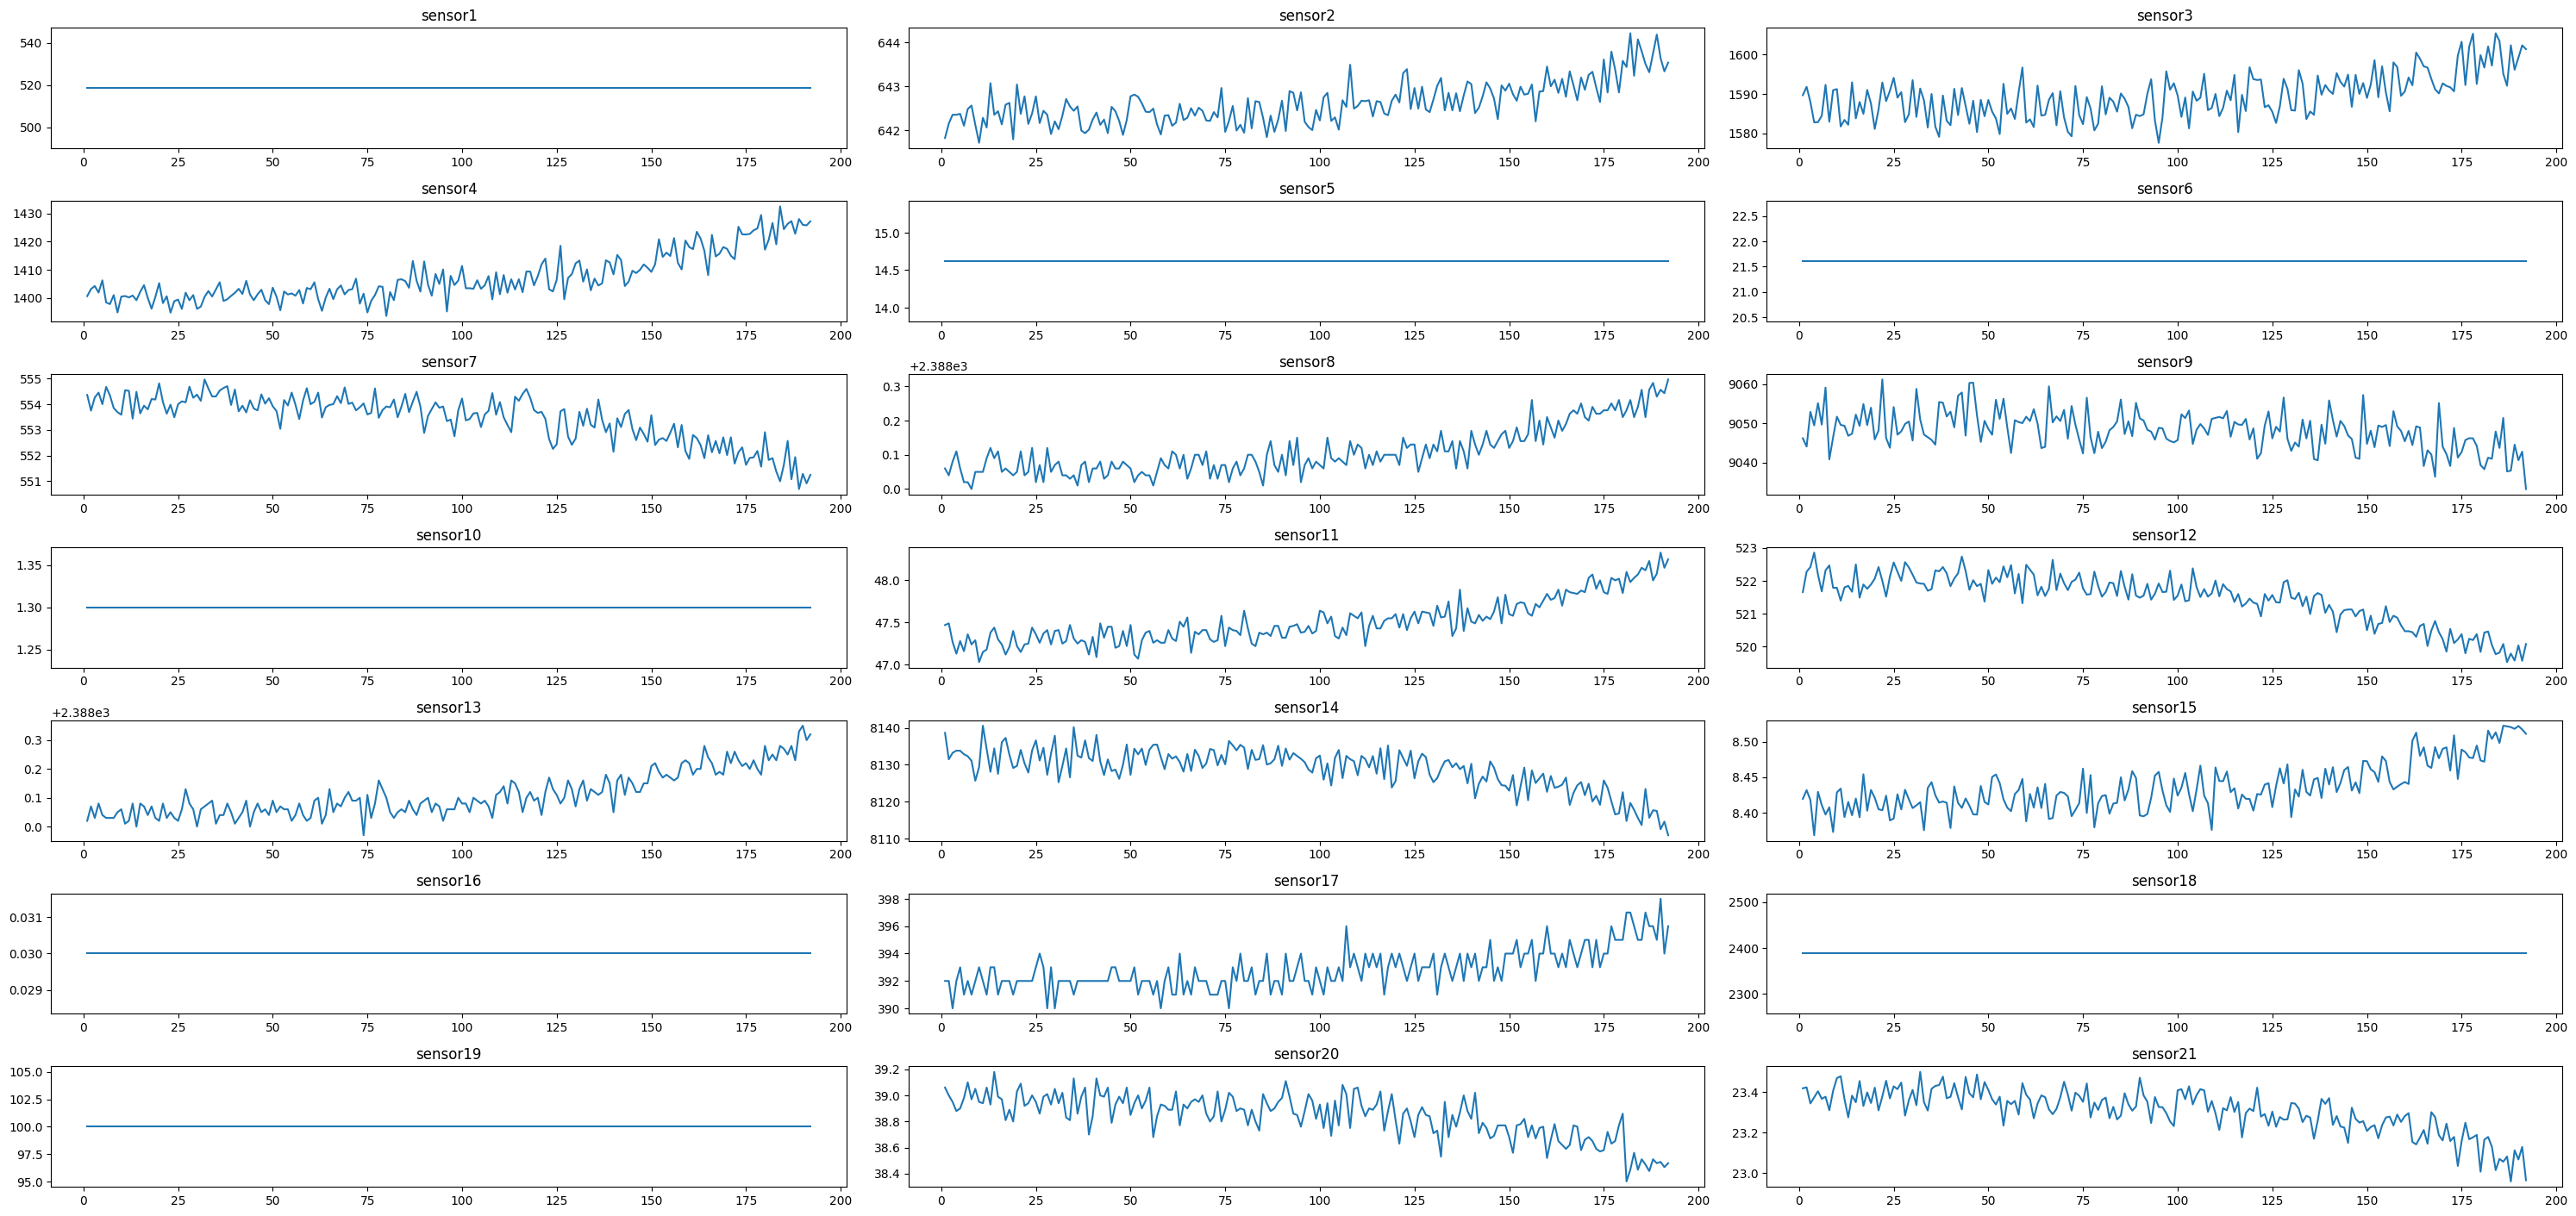

In [ ]:
plotSensorDataOfId(train, 1)

In [ ]:
def plotDataDistribution(data):
    sensors = []
    plt.figure(figsize=(30, 10))
    for i in range(21):
        sensor = 'sensor'+str(i+1)
        if(len(data[sensor].unique())>1):
            sensors.append(sensor)
            plt.subplot(3, 10, i+1)
            sns.distplot(data[sensor])
    plt.tight_layout()
    return sensors

<ipython-input-41-ab2dea49aac3>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[sensor])
<ipython-input-41-ab2dea49aac3>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[sensor])
<ipython-input-41-ab2dea49aac3>:9: UserWarning: 

`distplot` is a deprecated function and will be removed 

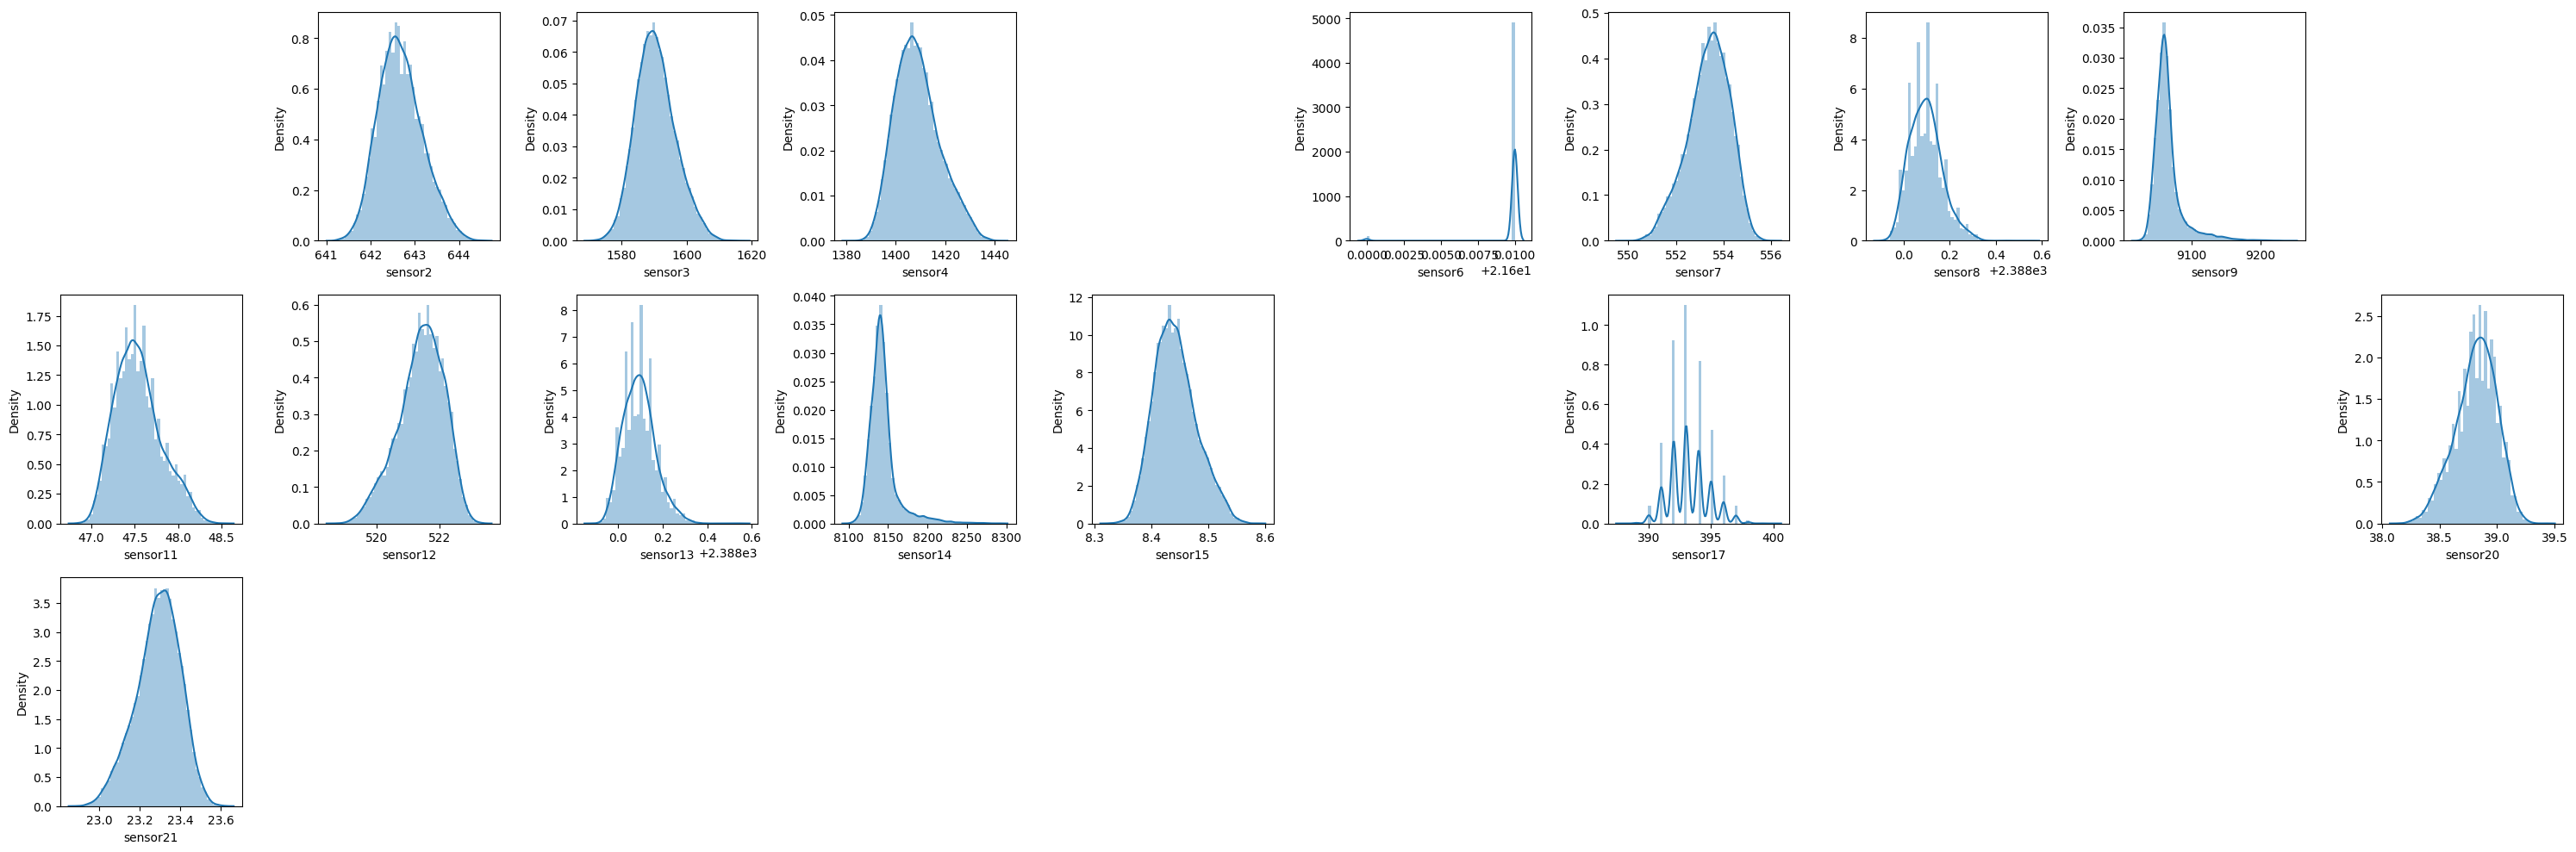

In [ ]:
# As of feature selection they often select: 7, 8, 9, 12, 16, 17, 20 => Why 16?
cols = plotDataDistribution(train)

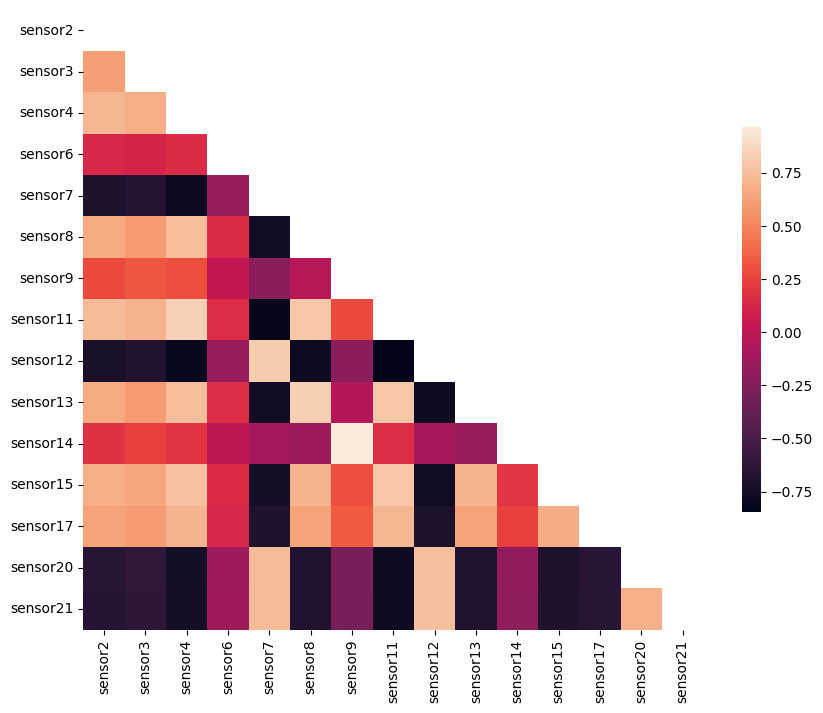

In [ ]:
def plotCorrelation(data):
    corr = data.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize=(10, 10))
    sns.heatmap(data.corr(), square=True, mask=mask, cbar_kws={"shrink": 0.5})

plotCorrelation(train[cols])

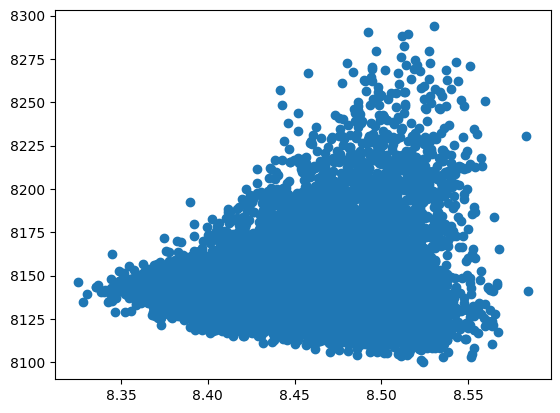

In [ ]:
plt.scatter(train['sensor15'].values, train['sensor14'].values)

In [ ]:
def plotCorrelationOfID(data, mcId):
    data1 = data[data['id'] == mcId]
    data1 = data1.drop(['id'], axis=1)
    corr = data1.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize=(10, 10))
    sns.heatmap(data1.corr(), square=True, mask=mask, cbar_kws={"shrink": 0.5})

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# Scale the data and return the scaled data in form of a df and the scaler (will generate the scaler if doesn't pass it)
def scaleData(data, scaler=None):
    scaled_fields = setting_cols + sensor_cols
    if scaler is None:
        scaler = StandardScaler().fit(data[scaled_fields].values)
    scaled_data = scaler.transform(data[scaled_fields].values)
    scaled_df0 = pd.DataFrame(scaled_data)
    scaled_df0.columns = scaled_fields
    scaled_df1 = data.copy()
    for i in range(len(scaled_fields)):
        theField = scaled_fields[i]
        scaled_df1[theField] = scaled_df0[theField]
    return scaled_df1, scaler

In [ ]:
# Scaled train
scaled_train, scaler = scaleData(train)
# Scaled test
scaled_test, scaler = scaleData(test, scaler)

<ipython-input-41-ab2dea49aac3>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[sensor])
<ipython-input-41-ab2dea49aac3>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[sensor])
<ipython-input-41-ab2dea49aac3>:9: UserWarning: 

`distplot` is a deprecated function and will be removed 

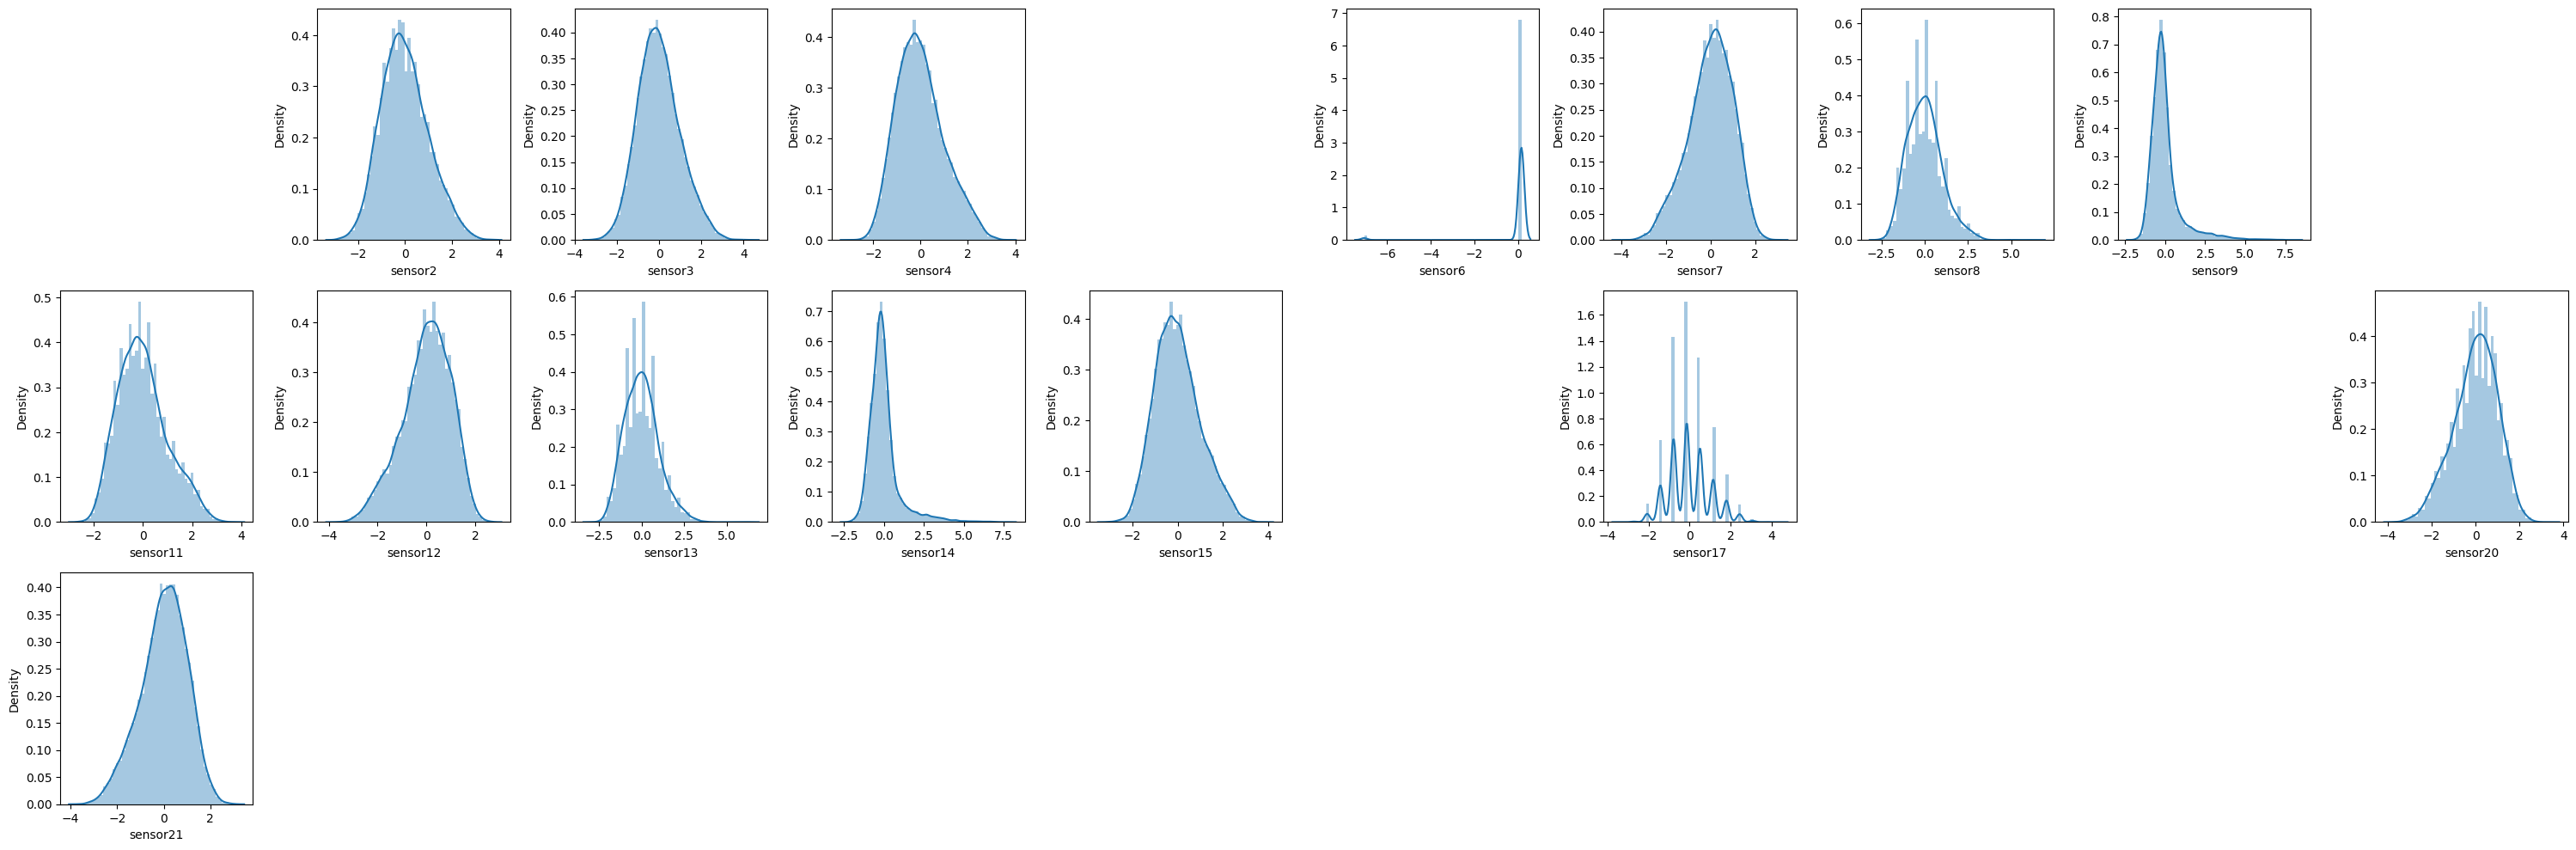

In [ ]:
# plot to make sure that the scaled data still keep its shape.
cols = plotDataDistribution(scaled_train)

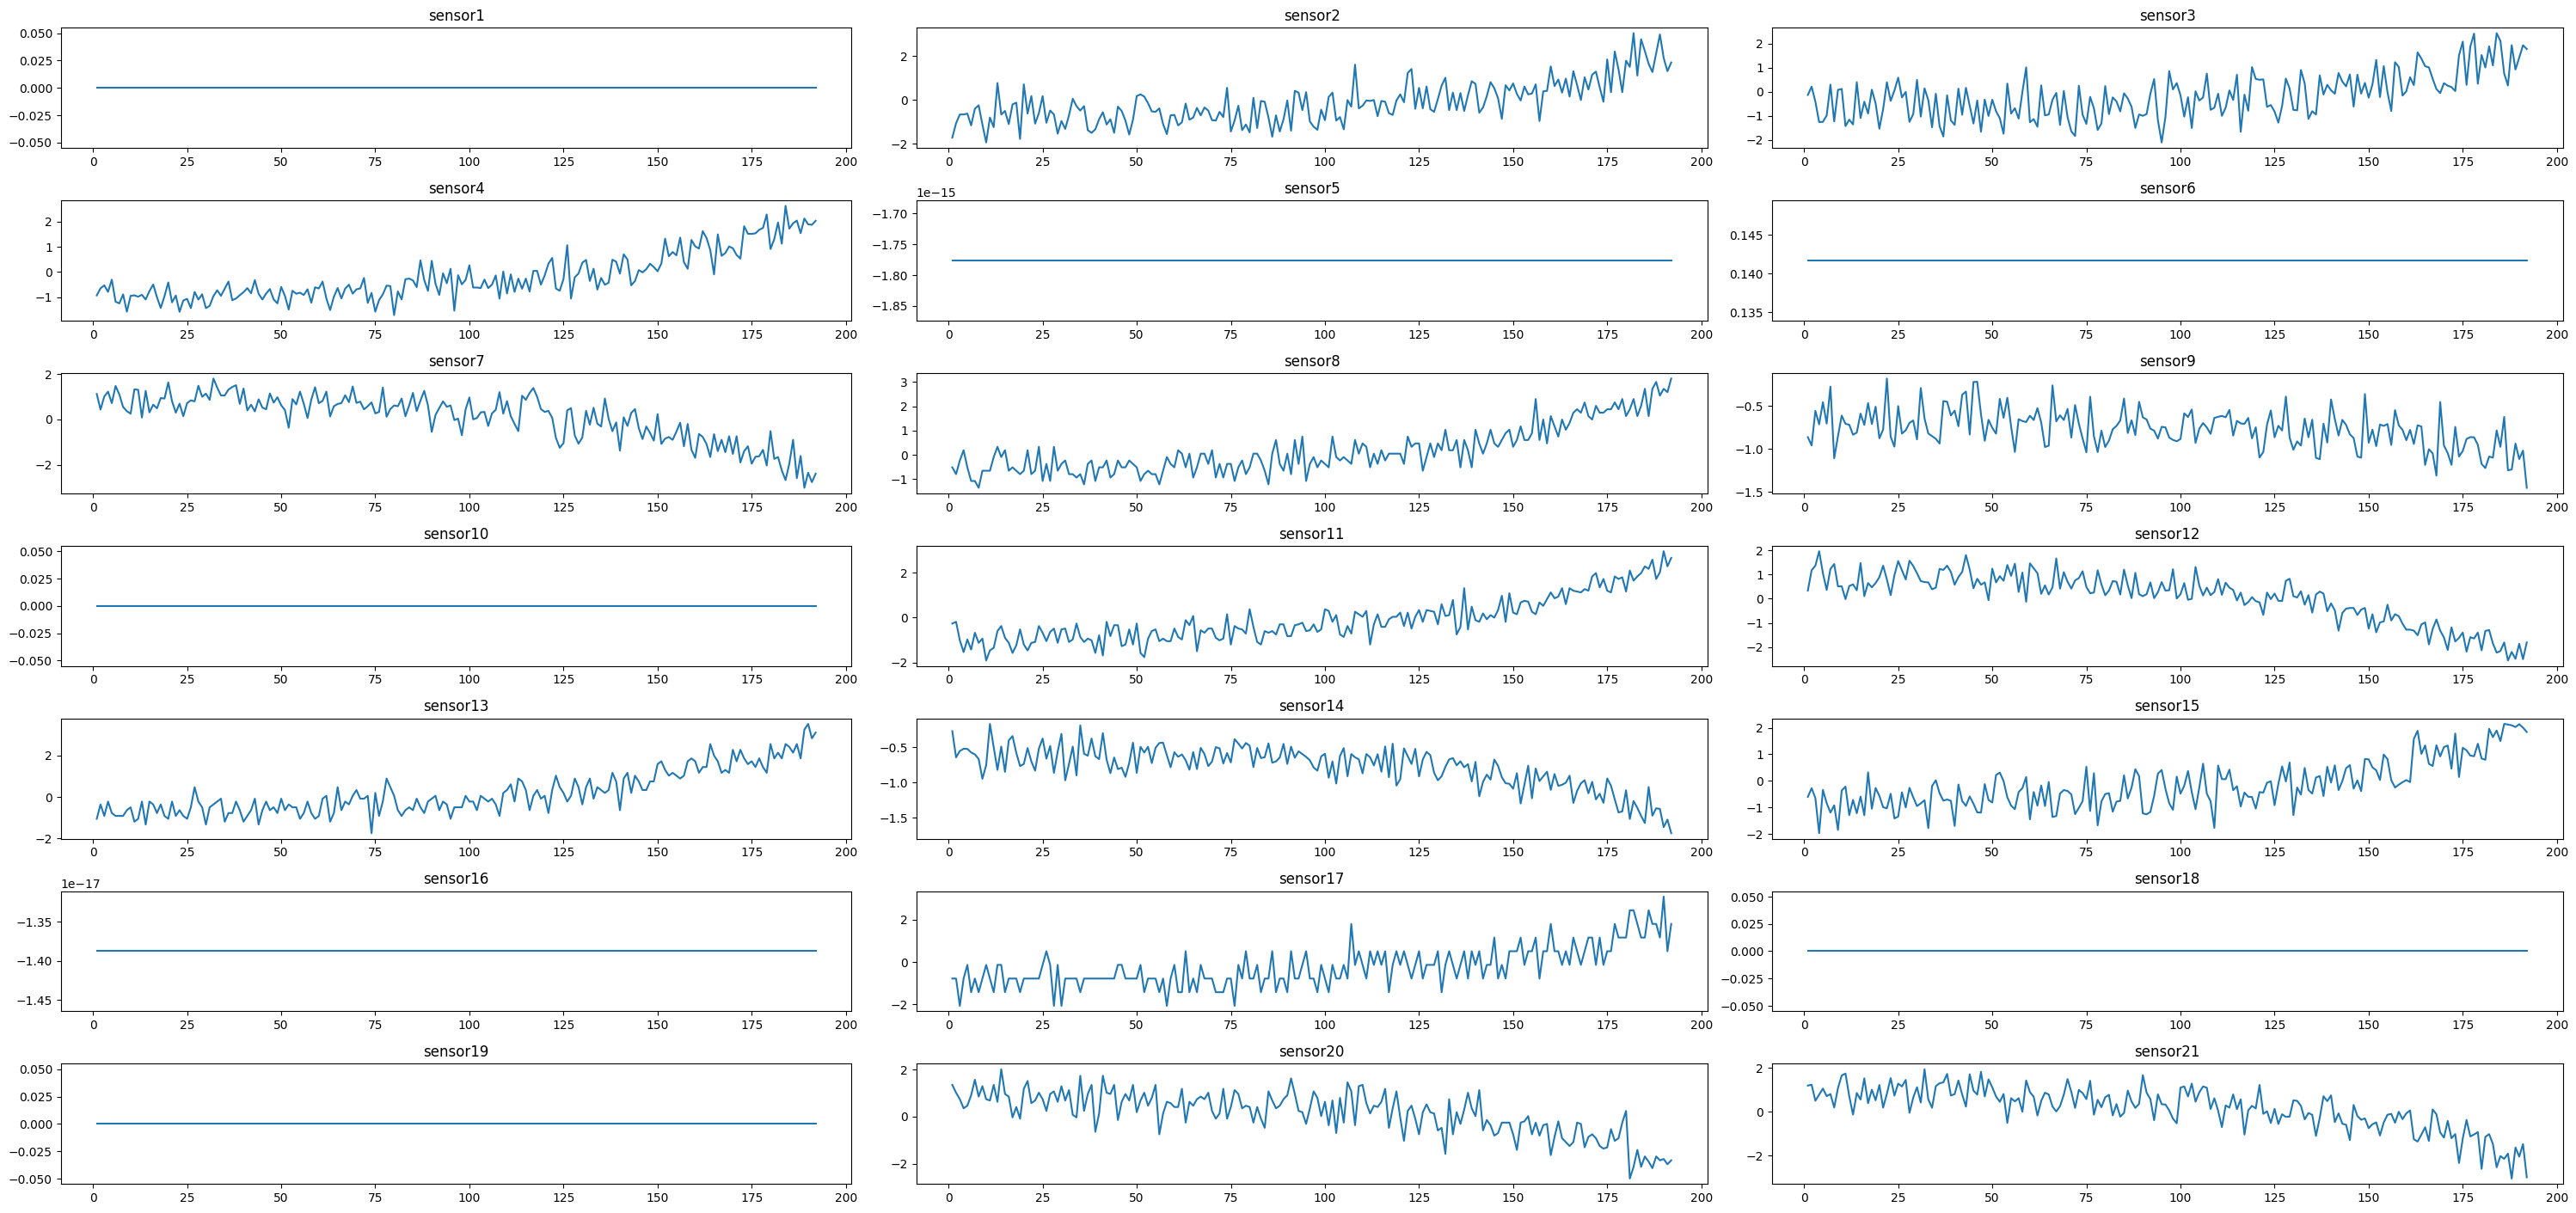

In [ ]:
plotSensorDataOfId(scaled_train, 1)

In [ ]:
import random
def getPieceWiseData(data, augmentStartCycle=None, augmentEndCycle=None, movingAverage=None):
    uniqueIds = data['id'].unique()
    if movingAverage is None:
        result = [data[data['id'] == mId].values for mId in uniqueIds]
    else:
        result = [data[data['id'] == mId].rolling(movingAverage).mean().dropna().values for mId in uniqueIds]
    maxlen = np.max([len(x) for x in result])
    # Augment the data now
    if augmentStartCycle is not None and augmentEndCycle is not None:
        result1 = []
        for mc in result:
            maxCycle = len(mc)
            for i in range(50):
                idx = random.randint(max([maxCycle - 145, 10]), max([maxCycle - 10, 10]))
                if len(mc[:idx, :]) > 0:
                    result1.append(mc[:idx, :])
        result = result1
    ruls = [min(mc[:, -1]) for mc in result]
    return result, ruls, maxlen

In [ ]:
# Use this last one only (prev one is a helper)
from keras.preprocessing.sequence import pad_sequences
def getPaddedSequence(data, pad_type='pre', maxlen=None, augmentStartCycle=None, augmentEndCycle=None, movingAverage=None):
    piece_wise, ruls, ml = getPieceWiseData(data, augmentStartCycle, augmentEndCycle, movingAverage)
    if maxlen is None: maxlen = ml
    padded_sequence = pad_sequences(piece_wise, padding=pad_type, maxlen=maxlen, dtype='float32')
    return padded_sequence, ruls, maxlen

In [ ]:
augmentStartCycle = 130
augmentEndCycle = 362
maxlen = 200
movingAverage = None
padded_train, train_ruls, maxlen = getPaddedSequence(scaled_train, maxlen=maxlen, augmentStartCycle=augmentStartCycle, augmentEndCycle=augmentEndCycle, movingAverage=movingAverage)
padded_test, test_ruls, maxlen = getPaddedSequence(scaled_test, maxlen=maxlen, movingAverage=movingAverage)


<Axes: ylabel='Count'>

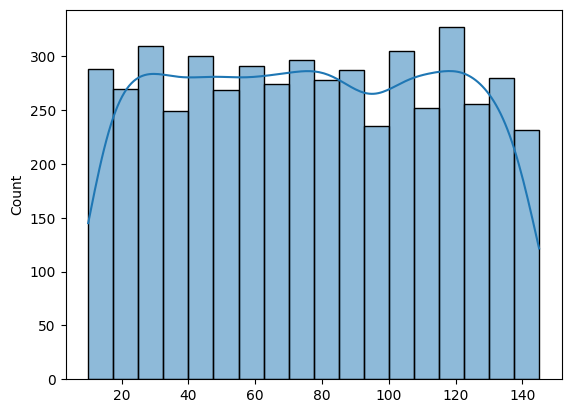

In [ ]:
sns.histplot(train_ruls, kde=True)

In [ ]:
def plotDataForIndex(data, theIndex):
    plt.figure(figsize=(30, 30))
    for i in range(5, 26):
        plt.subplot(7, 3, i-4)
        values = data[theIndex][:, i]
        plt.plot(range(len(values)) ,values)
        plt.title('sensor'+str(i-4))
        plt.tight_layout()

In [ ]:
from keras import regularizers
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, BatchNormalization, Bidirectional
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from keras.models import Model
from keras.callbacks import Callback
from keras.optimizers import Adam

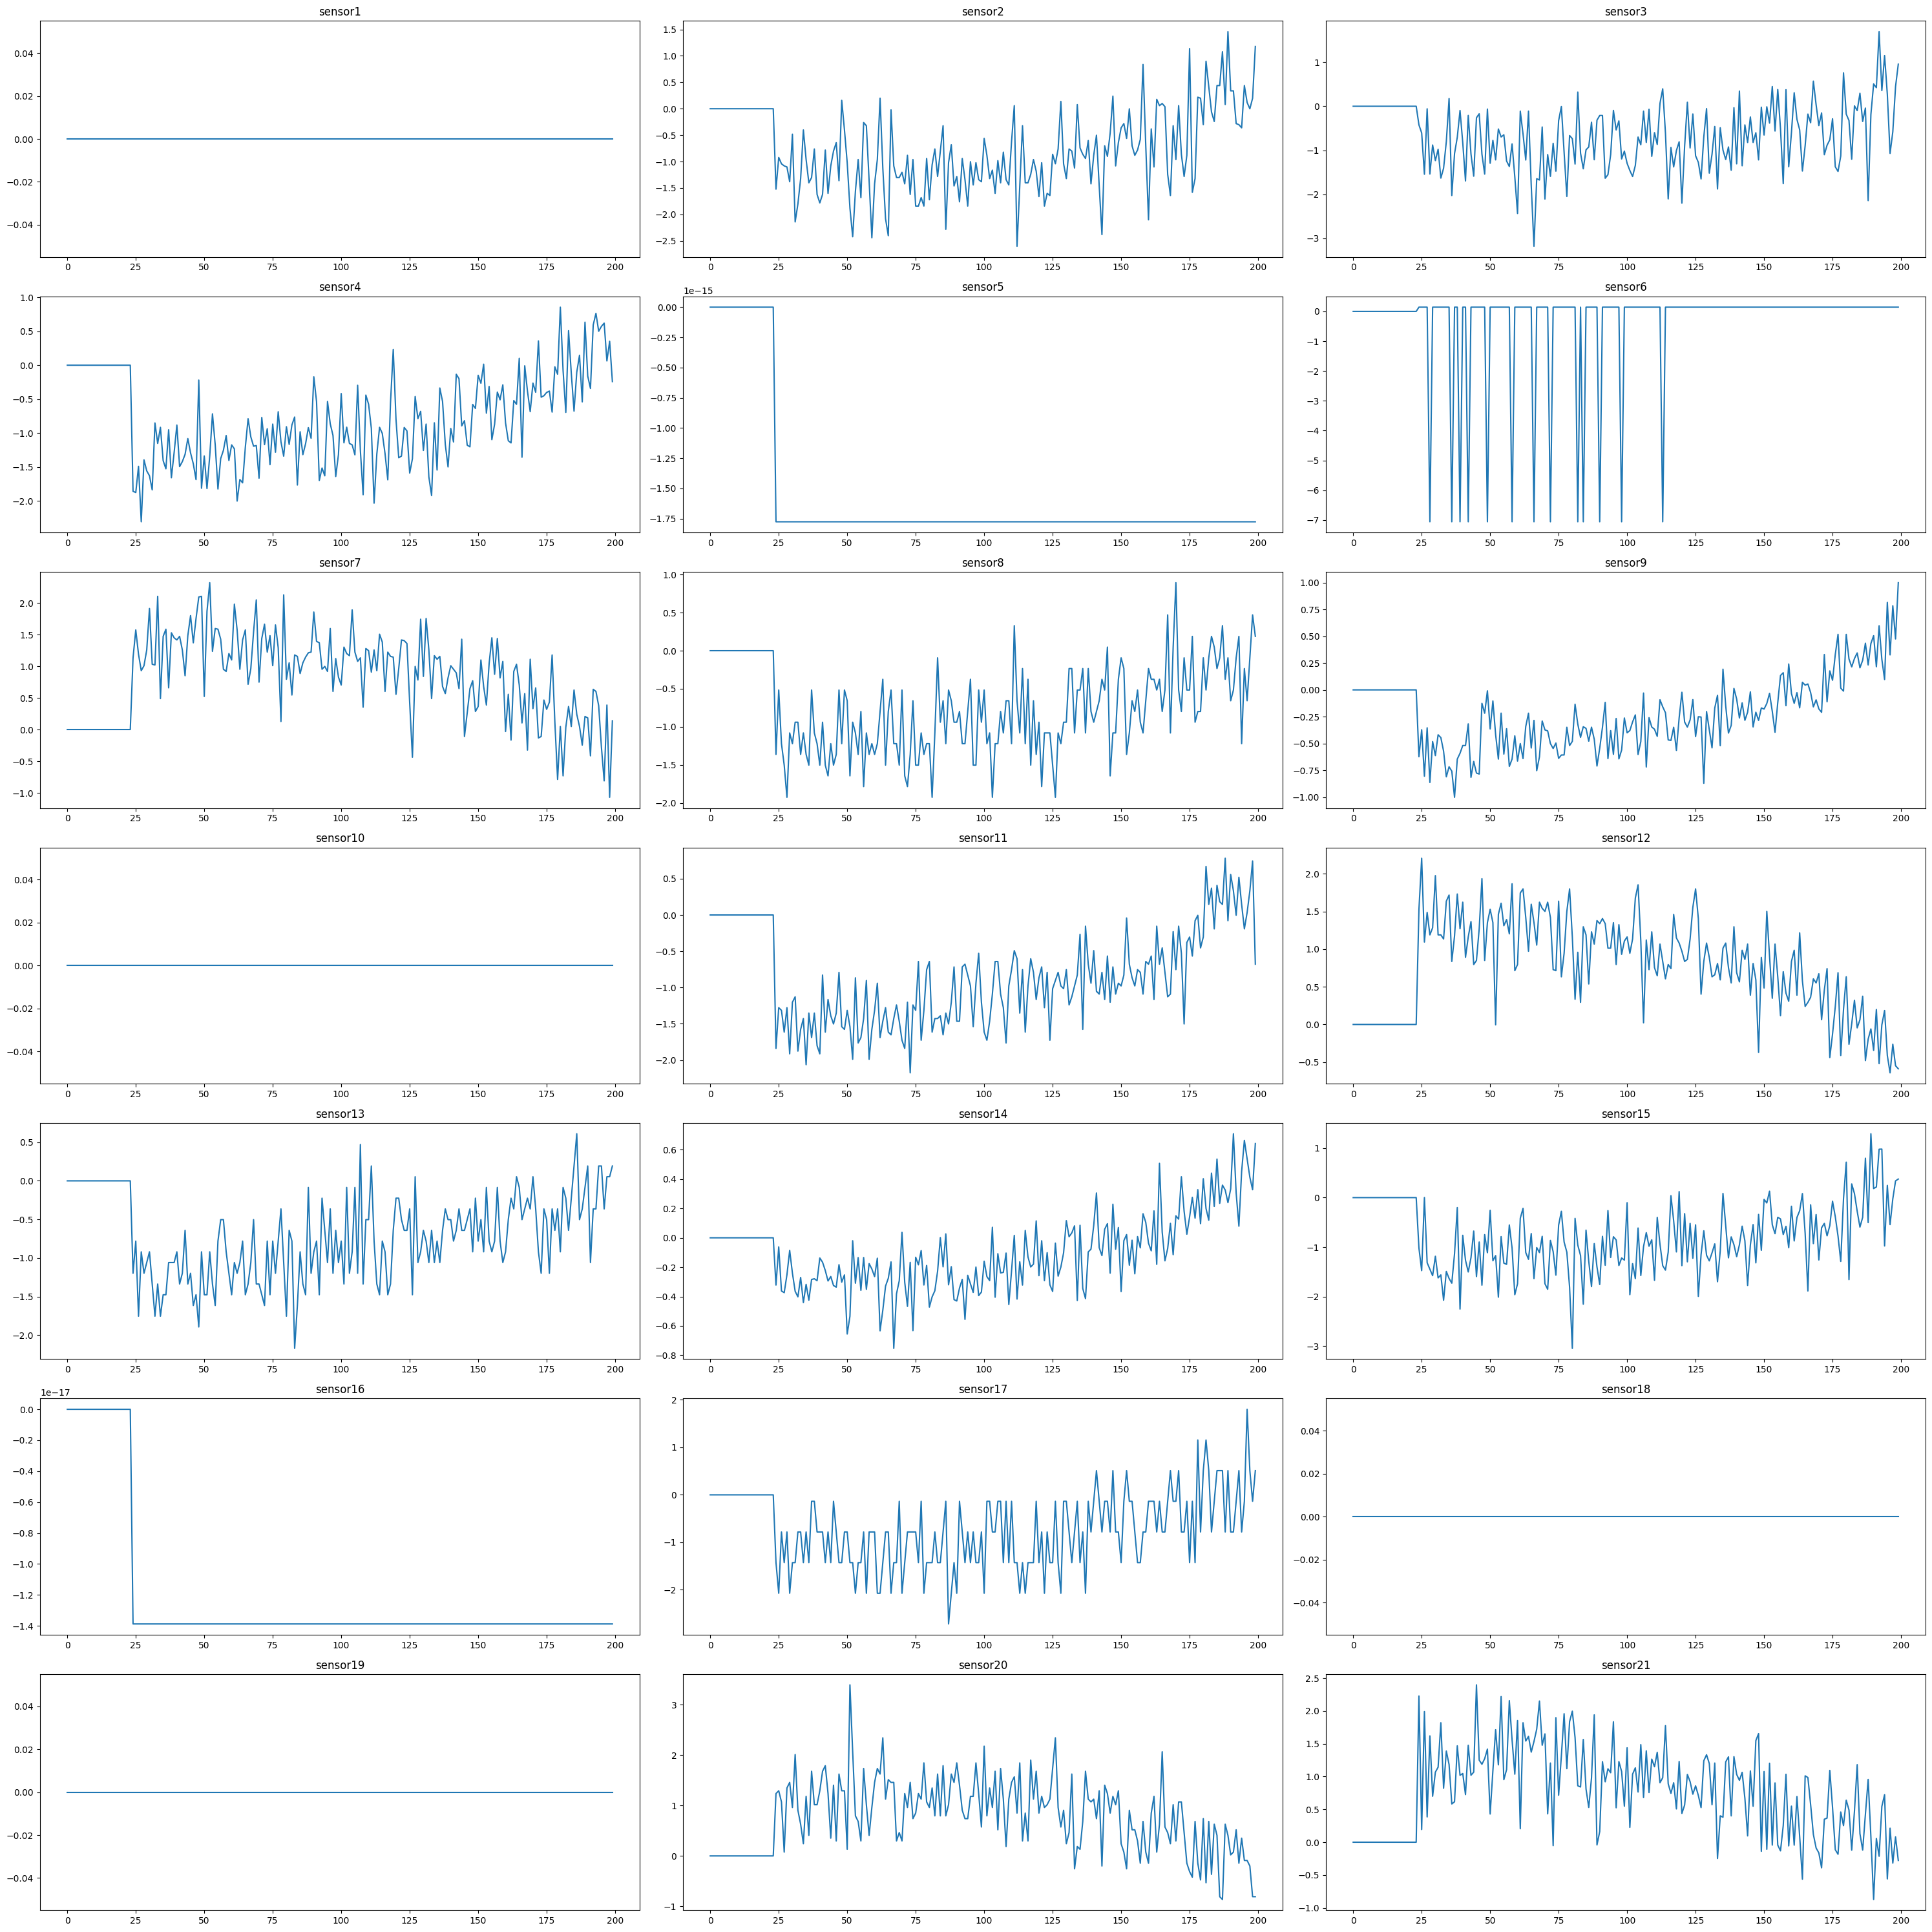

In [ ]:
plotDataForIndex(padded_train, 450)

In [ ]:
#Select sensors for the model
selected_sensors = [2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 17, 20, 21]
selected_sensors_indices = [x - 1 for x in selected_sensors]

In [ ]:
X_train = padded_train[:, :, 5:26][:, :, selected_sensors_indices]
X_test = padded_test[:, :, 5:26][:, :, selected_sensors_indices]

In [ ]:
y_train = np.array(train_ruls).reshape(-1, 1)
y_test = np.array(test_ruls).reshape(-1,1)

In [ ]:
numOfSensors = len(X_train[0][0])

In [ ]:
import codecs, json
def exportNPArrayToJSON(a, fileName):
    b = a.tolist()
    json.dump(b, codecs.open(fileName, 'w', encoding='utf-8'))

In [ ]:
test_FD = 'test_FD00' + str(setNumber) + ".json"
train_FD = 'train_FD00' + str(setNumber) + ".json"
test_RUL_FD = 'test_RUL_FD00' + str(setNumber) + ".json"
train_RUL_FD = 'train_RUL_FD00' + str(setNumber) + ".json"
exportNPArrayToJSON(X_test, test_FD)
exportNPArrayToJSON(y_test, test_RUL_FD)

In [ ]:
from keras import regularizers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten

In [ ]:
from tensorflow.keras.layers import Conv1D

In [ ]:
def createCNNLSTMModel(inputShape):
    cv1 = Conv1D(input_shape=inputShape, filters=18, kernel_size=2, strides=1, padding='same', activation='relu', name='cv1')
    bn1 = BatchNormalization(axis=-1)
    mp1 = MaxPooling1D(pool_size=2, strides=2, padding='same', name='mp1')

    cv2 = Conv1D(filters=36, kernel_size=2, strides=1, padding='same', activation='relu', name='cv2')
    bn2 = BatchNormalization(axis=-1)
    mp2 = MaxPooling1D(pool_size=2, strides=2, padding='same', name='mp2')

    cv3 = Conv1D(filters=72, kernel_size=2, strides=1, padding='same', activation='relu', name='cv3')
    bn3 = BatchNormalization(axis=-1)
    mp3 = MaxPooling1D(pool_size=2, strides=2, padding='same', name='mp3')

    bilstm1 = LSTM(64, return_sequences=True)
    bilstm_do1 = Dropout(0.2)
    bilstm2 = LSTM(64)
    bilstm_do2 = Dropout(0.2)

    dense1 = Dense(50, activation='relu')
    do1 = Dropout(0.2)

    output = Dense(1)

    model = Sequential([cv1, bn1, mp1, cv2, bn2, mp2, cv3, bn3, mp3, bilstm1, bilstm_do1, bilstm2, bilstm_do2, dense1, do1, output])
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [ ]:
def genetic_algorithm(X_train, y_train, population_size, generations):
    # Define hyperparameter search space
    hyperparameters = {
        'l1Nodes': [32, 64, 128],
        'l2Nodes': [32, 64, 128],
        'd1Nodes': [32, 64, 128],
        'd2Nodes': [8, 16, 32]
    }
    # Initialize population randomly
    population = []
    for _ in range(population_size):
        individual = {param: random.choice(values) for param, values in hyperparameters.items()}
        population.append(individual)

    # Evaluate fitness for each individual
    for individual in population:
        l1Nodes = individual['l1Nodes']
        l2Nodes = individual['l2Nodes']
        d1Nodes = individual['d1Nodes']
        d2Nodes = individual['d2Nodes']
        model = createCNNLSTMModel((maxlen, numOfSensors))
        model.fit(X_train, y_train, batch_size=32, epochs=4, verbose=0)
        individual['fitness'] = model.evaluate(X_train, y_train)[0]

    # Evolution loop
    for _ in range(generations):
        # Select parents
        parents = random.choices(population, k=2, weights=[1/ind['fitness'] for ind in population])
        # Crossover
        child = {}
        for param in hyperparameters.keys():
            parent_values = [parent[param] for parent in parents]
            child[param] = random.choice(parent_values)
        # Mutation
        if random.random() < 0.2:
            param_to_mutate = random.choice(list(hyperparameters.keys()))
            child[param_to_mutate] = random.choice(hyperparameters[param_to_mutate])
        # Evaluate fitness of the child
        l1Nodes = child['l1Nodes']
        l2Nodes = child['l2Nodes']
        d1Nodes = child['d1Nodes']
        d2Nodes = child['d2Nodes']
        model = createCNNLSTMModel((maxlen, numOfSensors))
        model.fit(X_train, y_train, batch_size=32, epochs=4, verbose=0)
        child['fitness'] = model.evaluate(X_train, y_train)[0]
        # Replace the least fit individual in the population with the child
        population.sort(key=lambda x: x['fitness'], reverse=True)
        population[-1] = child

    # Return the best individual
    population.sort(key=lambda x: x['fitness'])
    return population[0]


In [ ]:
# Using genetic algorithm to optimize hyperparameters
best_params = genetic_algorithm(X_train, y_train, population_size=10, generations=5)

157/157 [==============================] - 4s 22ms/step - loss: 163.7797 - mae: 9.8743


In [ ]:
# Extracting the best hyperparameters
best_l1Nodes = best_params['l1Nodes']
best_l2Nodes = best_params['l2Nodes']
best_d1Nodes = best_params['d1Nodes']
best_d2Nodes = best_params['d2Nodes']

In [ ]:
# Build model with best hyperparameters
best_model = createCNNLSTMModel((maxlen, numOfSensors))
best_model.fit(X_train, y_train, batch_size=32, epochs=4, verbose=0)

In [ ]:
# Evaluate the model on test data
test_loss, test_mae = best_model.evaluate(X_test, y_test)
test_predictions = best_model.predict(X_test)

4/4 [==============================] - 1s 13ms/step


In [ ]:
# Calculate RMSE
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_test, test_predictions, squared=False)

print("Test MAE:", test_mae)
print("Test RMSE:", rmse)

Test MAE: 14.679487228393555
Test RMSE: 19.00981861758383
